# Multiclass Support Vector Machine exercise

本练习中你将：
1. 实现一个用于SVM的完全向量化的**损失函数**
2. 实现损失函数的**解析梯度analytic gradient**的完全向量化表达式
3. 使用数值梯度**检查解析梯度的实现**
4. 使用**SGD随机梯度下降算法**来优化损失函数
5. **可视化**最终学习的权重


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from utils.datasets_util import load_cifar10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

这部分和`Q1_knn.ipynb`文件是一样的, 实现的功能和`code/utils/datasets_util.py`中的`get_CIFAR10_data`差不多

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../../datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


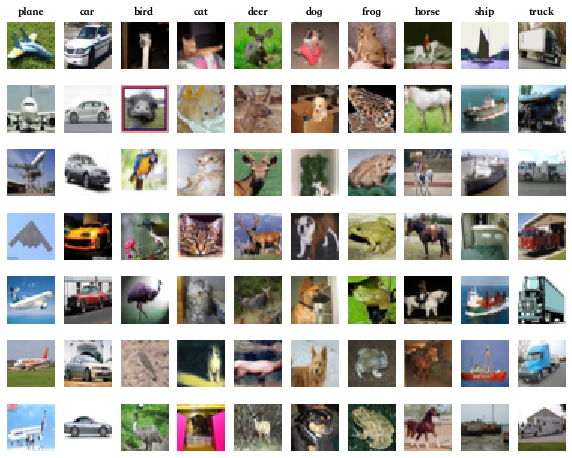

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

X_val = X_train[num_training:num_training + num_validation].astype(float)
y_val = y_train[num_training:num_training + num_validation]

X_train = X_train[:num_training].astype(float)
y_train = y_train[:num_training]

X_test = X_test[:num_test].astype(float)
y_test = y_test[:num_test]

# We will also make a development set, which is a small subset of
# the training set.
# 从训练集中划分出一个小的训练集，用来快速验证学习率和检查代码
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask].astype(float)
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
# 把image转换成行向量，即(49000, 32, 32, 3)→(49000,32*32*3), 作为后续SVM的输入
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,) [130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


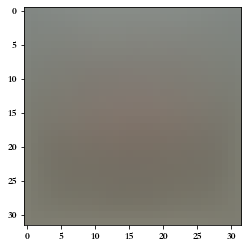

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# 1. 计算图像的均值（不是通道均值）
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape, mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

所以图像的均值就是灰不溜秋的一团（所有颜料混在一起就是黑的。。。）

In [7]:
# second: subtract the mean image from train and test data
# 2. 从数据集中减去图像的均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# 3. 把bias的维度以全1向量的形式添加到数据的后面（bias的小技巧），这样SVM只需要优化权重W即可
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


+ <https://scikit-learn.org/stable/modules/svm.html>
+ <https://scikit-learn.org/stable/modules/kernel_approximation.html#kernel-approximation>

## SVM Classifier
+ 这部分代码要在**utils/classifiers/linear_svm.py**中实现
+ 补全函数使用循环评估多类SVM损失函数（multiclass SVM loss function）的`compute_loss_naive`

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from utils.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.918487


In [10]:
grad.shape,grad[:2:10]

((3073, 10),
 array([[-35.05421486,   2.14617547,  14.47854073,  -8.85755416,
          19.99795882,  25.02679678,  34.59370278,   5.10841898,
         -21.973812  , -35.46601253]]))

+ 现在上述函数返回的`grad`梯度值目前全都是0，在函数`svm_loss_naive`中对SVM损失函数求导并实现梯度计算。你会发现把这些代码插入到现有函数中会很有用。
+ 为了检查是否正确实现了求解梯度，可以对损失函数的梯度进行数值估计并比较数值估计和你刚刚实现的梯度结果，我们在下面为你提供了这些代码

In [11]:
# 实现好了求梯度的代码后，使用下面的代码重新计算梯度，并使用我们提供的代码进行检查

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 随机选择几个维度进行梯度的数值计算，将其与你实现的解析梯度结果进行比较，两种计算结果在所有维度上应该都是基本相等的
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("with regularization")
# 再使用有正则项的结果检查一遍梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.046216 analytic: -4.046216, relative error: 4.437099e-11
numerical: -11.568399 analytic: -11.522069, relative error: 2.006483e-03
numerical: -10.952688 analytic: -10.952688, relative error: 4.150327e-11
numerical: -0.307474 analytic: -0.307474, relative error: 5.462039e-10
numerical: -10.737869 analytic: -10.737869, relative error: 1.441145e-11
numerical: 8.583607 analytic: 8.583607, relative error: 1.405371e-11
numerical: 11.095140 analytic: 11.095140, relative error: 2.727278e-11
numerical: 0.554017 analytic: 0.554017, relative error: 3.856418e-10
numerical: 12.536275 analytic: 12.536275, relative error: 1.866657e-11
numerical: -0.608136 analytic: -0.608136, relative error: 4.331367e-10
with regularization
numerical: -2.699862 analytic: -2.702007, relative error: 3.971888e-04
numerical: -18.798376 analytic: -18.798376, relative error: 2.456281e-11
numerical: 28.383990 analytic: 28.383990, relative error: 4.026093e-12
numerical: -15.382817 analytic: -15.382817, relative 

### 问题1:

+ 有时候梯度检查会不完全匹配，造成这种差异的原因是什么？
+ 造成这一差异的原因会很影响程序的正确结果吗？
+ 一个简单的梯度检查失败的例子是什么？（提示：SVM的损失函数严格来说不可微分，strictly speaking differentiable）

**你的回答:** 
+ 数值解是近似解，当位于SVM损失函数不可导的点时，两个结果会不一样
+ 由于SVM loss function中存在max，简化表示：$f(x)=max(x,0)$
+ 对于数值求解来说：
    + $x=0,f(x)=0$
    + $x=0.001,f(x)=0.001$, $x=-0.001,f(x)=0$
    + $dx=\frac{f(x+\delta x)-f(x)}{\delta x}$
    + 右导数：$\lim_{x \to 0^+}\frac{f(0.001)-f(0)}{0.001}=1$
    + 左导数：$\lim_{x \to 0^-}\frac{f(-0.001)-f(0)}{-0.001}=0$

<img src="../../images/singleSideGradient.jpg" width="50%" />

In [12]:
# fail calculate gradient
# X:(N,D) N=1, D=3
# W:(D,C) D=3, C=3
# Y:(N, ) 
X_example = np.array([[1,1,1]],dtype=float) 
Y_example=np.array([2])
W_example=np.array([[0,0,1],[0,0,1],[0,2,1]],dtype=float)
loss, grad = svm_loss_naive(W_example, X_example, Y_example, 0.0)
f = lambda w: svm_loss_naive(w, X_example, Y_example, 0.0)[0]
grad_numerical = grad_check_sparse(f, W_example, grad)

numerical: 0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000000, relative error: nan


/Users/huangshan/Documents/DailyStudy/cs231n/code/Assignment1/utils/gradient_check.py:132: RuntimeWarning: invalid value encountered in double_scalars
  (abs(grad_numerical) + abs(grad_analytic))


In [76]:
# 接下来实现svm_loss_vectorized,向量化求解loss的函数，对比和使用循环计算梯度所花费的时间
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 向量化计算的结果应该和非向量化的差不多，但是速度要快得多
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.918487e+00 computed in 0.175097s
Vectorized loss: 8.918487e+00 computed in 0.003261s
difference: -0.000000


100/6≈17倍

In [89]:
# 完成svm_loss_vectorized的视线，通过向量方式计算损失函数的梯度

# 原始的实现和向量化实现的结果应该是匹配的，但是后者要快很多
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.084311s
Vectorized loss and gradient: computed in 0.004064s
difference: 0.000000


80/4=20，快大概20倍。

### Stochastic Gradient Descent

+ 截止目前已经完成了损失和梯度的向量化高效的表达，
+ 同时梯度计算的结果是和数值梯度一致的。（除了在严格不可微的地方数值梯度是一种近似计算之外不相等）
+ 接下来准备使用随机梯度下降来最小化loss

In [92]:
# 在文件linear_classifier.py中,在函数LinearClassifier.train() 中实现SGD，然后运行以下代码
from utils.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

# batch_size: int = 200,
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 404.005543
iteration 100 / 1500: loss 239.166926
iteration 200 / 1500: loss 146.281994
iteration 300 / 1500: loss 89.882465
iteration 400 / 1500: loss 55.683737
iteration 500 / 1500: loss 35.904876
iteration 600 / 1500: loss 23.461466
iteration 700 / 1500: loss 16.197489
iteration 800 / 1500: loss 11.200819
iteration 900 / 1500: loss 9.367775
iteration 1000 / 1500: loss 7.068749
iteration 1100 / 1500: loss 6.180127
iteration 1200 / 1500: loss 5.749673
iteration 1300 / 1500: loss 5.910149
iteration 1400 / 1500: loss 5.365716
That took 2.979496s


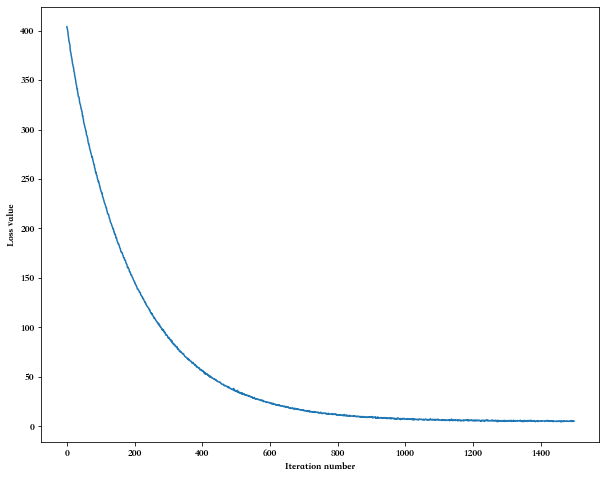

In [93]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# 一个很有效的debug策略就是把损失函数随着迭代次数变化的图像画出来
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [94]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
# 完成LinearSVM.predict函数，评估在训练集和验证集上的表现
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.376245
validation accuracy: 0.390000


In [95]:
np.mean([0,0,1,1,0])

0.4

看起来损失低了很多，但是可以看出来准确率其实没多少。。。果然是比较初级的网络

In [104]:
import math
print(math.log10(1e-7), 10**(-7)) # 学习率范围
print(math.log10(5e-5), 10**(-4.3))
print(10**np.random.uniform(-7,-4.3))

print(math.log10(2.5e4), 10**(4.39)) # 正则强度值范围
print(math.log10(5e4), 10**(4.69))
print(10**np.random.uniform(-7,-4.3)) # W初始化的时候是：self.W = 0.001 * np.random.randn(dim, num_classes) 值很小

-7.0 1e-07
-4.301029995663981 5.011872336272725e-05
2.0967191618703334e-05
4.3979400086720375 24547.089156850285
4.698970004336019 48977.881936844664
5.548328673917125e-07


In [121]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# 通过验证集对超参进行微调（正则项的强度和学习率）,可以使用不同的学习率和正则项强度区间来进行实验
# 如果调试的还不错,验证集上可以得到0.4的准确率
learning_rates = [1e-7, 5e-5]
# [1e-7,5e-5]→ 10**uniform(-7,-4.3)
regularization_strengths = [2.5e4, 5e4]
# [2.5e4, 5e4]→ 10**uniform[4.39,4.69]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
# 结果用一个字典表示,results[(learning_rate, regularization_strength)]=(training_accuracy, validation_accuracy)
results = {}
best_val = -1   # 比较大小，所以初始值设置小一点，方便后续覆盖 The highest validation accuracy that we have seen so far.
best_svm = None # 实现了最佳验证准确率的LinearSVM的超参 The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# CS31n_2017_lecture6 77页, 可以使用reg=10**uniform(-5,5)这样的方式采样，不均匀采样
np.random.seed=1
for i in range(10):
    learning_rate = 10**np.random.uniform(-7,-4.3) # 根据排序后的范围，在精细调一次
    regularization_strength = 10**np.random.uniform(4.39,4.69)
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                        num_iters=1500, verbose=False)
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred) 
    results[(learning_rate,regularization_strength)]=(training_accuracy,validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.122815e-07 reg 3.756499e+04 train accuracy: 0.371490 val accuracy: 0.374000
lr 1.976727e-07 reg 2.757458e+04 train accuracy: 0.375367 val accuracy: 0.390000
lr 2.764871e-07 reg 3.311304e+04 train accuracy: 0.372837 val accuracy: 0.381000
lr 2.871218e-07 reg 2.714846e+04 train accuracy: 0.369061 val accuracy: 0.360000
lr 3.006898e-07 reg 2.668795e+04 train accuracy: 0.369918 val accuracy: 0.380000
lr 3.585944e-07 reg 3.841526e+04 train accuracy: 0.351204 val accuracy: 0.354000
lr 2.957493e-06 reg 4.661584e+04 train accuracy: 0.217367 val accuracy: 0.201000
lr 3.119679e-06 reg 3.736673e+04 train accuracy: 0.290816 val accuracy: 0.313000
lr 9.845182e-06 reg 4.487784e+04 train accuracy: 0.181714 val accuracy: 0.173000
lr 1.045956e-05 reg 3.002951e+04 train accuracy: 0.204286 val accuracy: 0.229000
best validation accuracy achieved during cross-validation: 0.390000


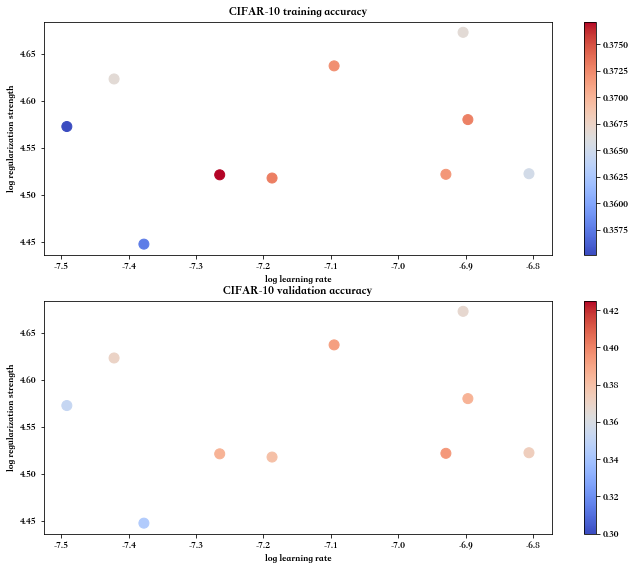

In [117]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)

plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
# plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap=plt.cm.coolwarm,vmax=0.425,vmin=0.3)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

+ 可以看看这个人的：<https://github.com/amanchadha/stanford-cs231n-assignments-2020/blob/master/assignment1/svm.ipynb>
+ 交叉验证对超参的选择策略不太一样，画出来的图也不太一样

In [110]:
results = {}
best_val = -1   # 比较大小，所以初始值设置小一点，方便后续覆盖 The highest validation accuracy that we have seen so far.
best_svm = None # 实现了最佳验证准确率的LinearSVM的超参 The LinearSVM object that achieved the highest validation rate.

for i in range(10):
    learning_rate = 10**np.random.uniform(-7.5,-6.8) # 根据排序后的范围，再精细调一次
    regularization_strength = 10**np.random.uniform(4.39,4.69)
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                        num_iters=1500, verbose=False)
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred) 
    results[(learning_rate,regularization_strength)]=(training_accuracy,validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.222711e-08 reg 3.737291e+04 train accuracy: 0.355122 val accuracy: 0.352000
lr 3.787243e-08 reg 4.198417e+04 train accuracy: 0.366612 val accuracy: 0.370000
lr 4.193668e-08 reg 2.802954e+04 train accuracy: 0.357694 val accuracy: 0.344000
lr 5.433711e-08 reg 3.320953e+04 train accuracy: 0.377122 val accuracy: 0.385000
lr 6.498062e-08 reg 3.294843e+04 train accuracy: 0.372939 val accuracy: 0.380000
lr 8.033158e-08 reg 4.335041e+04 train accuracy: 0.372204 val accuracy: 0.392000
lr 1.177053e-07 reg 3.324985e+04 train accuracy: 0.371714 val accuracy: 0.394000
lr 1.248342e-07 reg 4.705722e+04 train accuracy: 0.366592 val accuracy: 0.367000
lr 1.268885e-07 reg 3.801172e+04 train accuracy: 0.372857 val accuracy: 0.385000
lr 1.563526e-07 reg 3.329851e+04 train accuracy: 0.365204 val accuracy: 0.373000
best validation accuracy achieved during cross-validation: 0.394000


确实可以到0.4左右。。。

In [122]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


虽然我上面的结果只到0.39，没有<https://github.com/amanchadha/stanford-cs231n-assignments-2020/blob/master/assignment1/svm.ipynb>这个人好，但是测试集结果却比他好。。

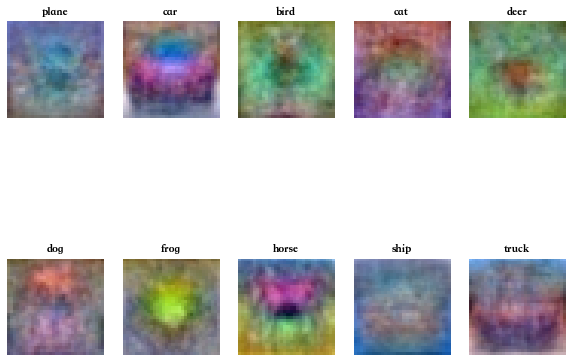

In [123]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
# 可视化学习到的权重,根据你选择的学习率和正则强度，显示出来的可能好可能不好
# 如果显示不好的话，可以用默认的learning_rate=1e-3, reg=1e-5显示看看
w = best_svm.W[:-1,:] # strip out the bias, W[-1]是b偏置项
w = w.reshape(32, 32, 3, 10) # W.shape,3072*10,32*32=1024,1024*3=3072, reshape(32,32,3,10)
w_min, w_max = np.min(w), np.max(w) # 记录最大和最小值用来帮助缩放到0~255范围进行显示
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

+ 显示结果和PPT里的差不多
+ 变换前：X∈[0.2,0.9],变换后：Y∈[0,255]
$$\frac{X-0.2}{0.9-0.2}=\frac{Y-0}{255-0}\rightarrow Y=\frac{X-0.2}{0.9-0.2}\times 255$$

### Inline question 2:
描述你的SVM权重可视化后的结果，简洁描述一下为什么看起来是这个样子的

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:**
+ 飞机是找蓝色的物体，汽车前挡风玻璃黑色，轮胎黑色，车前盖红色，鸟的背景是绿色，说明鸟大部分在树上。鹿的背景也是绿色，说明在草丛/草原
+ 青蛙本身是绿色，则画面中央/主体是绿色，常见马是红棕色，马头可能朝向左，也可能朝向右。
+ 轮船在海里，所以背景蓝色。

# 测试代码

**SVM的loss向量化**

In [13]:
X_example = np.array([[1,1,1],[2,2,2]],dtype=float) 
W_example = np.array([[0.5,0.5],[0.2,0.2],[0.1,0.1]],dtype=float) 
X_example.dot(W_example)

array([[0.8, 0.8],
       [1.6, 1.6]])

In [41]:
X_example = np.array([[1,2,3],[4,5,6]],dtype=float) 
W_example = np.array([[0.1,0.2],[0.1,0.1],[0.1,0.1]],dtype=float) 
Y_example=[1,1]

scores = X_example.dot(W_example)
print(f"scores:\n {scores}")

# correct_score = scores[:,Y_example]
correct_score = scores[[0,1],Y_example]
# correct_score = scores[np.arange(X_example.shape[0]), Y_example].reshape(-1, 1)
print(f"correct_score: \n {correct_score}")
margin = scores-correct_score+1.0
print(f"margin:\n {margin}")

margin_loss = margin[margin>0]
print(f"margin_loss: \n {margin_loss}, \n sum is {np.sum(margin_loss)/2}")

scores:
 [[0.6 0.7]
 [1.5 1.9]]
correct_score: 
 [0.7 1.9]
margin:
 [[ 0.9 -0.2]
 [ 1.8  1. ]]
margin_loss: 
 [0.9 1.8 1. ], 
 sum is 1.8499999999999999


In [27]:
a=np.array([[1,2,3],
           [4,5,6],
           [7,8,9]])
a[[0,1,2],[0,1,2]]

array([1, 5, 9])

确实有这种索引的写法，详见：<https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing>
<img src="../../images/np_slice.jpg" width="100%">

**SVM的导数向量化**

In [59]:
X_example = np.array([[1,2,3],[4,5,6]],dtype=float) 
num_train = X_example.shape[0]
W_example = np.array([[0.1,0.2],[0.1,0.1],[0.1,0.1]],dtype=float) 
Y_example=[1,1]
scores = X_example.dot(W_example)
correct_score = scores[[0,1],Y_example]
margin = np.maximum(0,scores-correct_score+1.0,dtype=float)
margin[range(num_train),Y_example] = 0
margin_loss = np.sum(margin)
print(f"margin_loss: \n {margin_loss}, margin shape is {margin.shape} num_train_{num_train} X class_{W_example.shape[1]}")

margin_loss: 
 2.6999999999999997, margin shape is (2, 2) num_train_2 X class_2


In [83]:
# coefficient
X_example = np.array([[1,2,3],[4,5,6]],dtype=float) 
W_example = np.array([[0.1,0.2],[0.1,0.1],[0.1,0.1]],dtype=float) 
Y_example=[1,1]

margin = np.maximum(0,scores-correct_score+1.0,dtype=float)
margin[range(num_train),Y_example] = 0
print(f"margin \n {margin}")
coeff_mat = np.zeros_like(margin) # coeff_mat.shape (2,2)
print(margin>0)
coeff_mat[margin>0] = 1
print(f"true label coeff: {np.sum(coeff_mat, axis=1), np.sum(coeff_mat, axis=1).shape}")
coeff_mat[range(num_train),Y_example] = -np.sum(coeff_mat, axis=1)

dW = X_example.T.dot(coeff_mat)  # dW.shape=W_example.shape (3,2)  X_example.T.shape (3,2) 
print(dW)

margin 
 [[0.9 0. ]
 [1.8 0. ]]
[[ True False]
 [ True False]]
true label coeff: (array([1., 1.]), (2,))
[[ 5. -5.]
 [ 7. -7.]
 [ 9. -9.]]


# 求导公式推导

In [19]:
X_dev[1,:20],X_dev[1,:20].T

(array([-34.64189796,  21.01826531,  94.52608163, -40.05569388,
         15.65195918,  93.24597959, -55.96055102,   0.85671429,
         82.52363265, -45.48467347,  12.41457143,  89.21706122,
        -49.094     ,   9.85991837,  84.823     , -54.76759184,
          3.22232653,  81.29397959, -52.29373469,   3.78755102]),
 array([-34.64189796,  21.01826531,  94.52608163, -40.05569388,
         15.65195918,  93.24597959, -55.96055102,   0.85671429,
         82.52363265, -45.48467347,  12.41457143,  89.21706122,
        -49.094     ,   9.85991837,  84.823     , -54.76759184,
          3.22232653,  81.29397959, -52.29373469,   3.78755102]))

![img](../../images/derive.jpg)

<img src="../../images/svm_loss.jpg" width="50%">
<img src="../../images/svm_loss2.jpg" width="30%">'

默认假设x的维度是(49000,3072),则对于10分类
$$y=wx+b$$
+ $x:49000\times 3072, w:3072\times 10, b:1\times 10$(每个样本的xw输出是10，每个样本的10个输出上分别加上b的10个数字，广播), 
+ $y:49000\times 10$

为了只优化w，即把b合并到w中，可以
+ 在每个样本后面添加一个1,即3072+1
+ 则对于X_train来说，就是添加一个全1的列
+ 则变成了 $y=wx$
+ $X:49000\times 3073, W:3073\times 10,Y:49000\times 10$,和上面的是等价的

关于求导，参考<https://cs231n.github.io/optimization-1/>，可以表示为：

<img src="../../images/gradient_Vec.jpg" width="70%">
<img src="../../images/gradient_Vec2.jpg" width="40%">

感知机结构绘制：
+ <https://en.wikipedia.org/wiki/Perceptron>
+ <https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975>
+ <https://www.javatpoint.com/single-layer-perceptron-in-tensorflow>
+ <https://epynn.net/Dense.html>
+ <https://stackoverflow.com/questions/53851652/not-fully-connected-layer-in-tensorflow>
+ <https://sebastianraschka.com/faq/docs/fc-to-conv.html>